In [2]:
import numpy as np
import pulp as plp
import random
import matplotlib.pyplot as plt
import time
import networkx as nx
from tqdm import tqdm
%matplotlib notebook

In [3]:
def frustration_count(G):
    s = 0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            s+=1
    return s

In [4]:
def color_of_frustration(G):
    
    positive=0
    negative=0
    for n1,n2,val in G.edges.data():
        if G.nodes[n1]['color']==G.nodes[n2]['color']:
            
            if G.nodes[n1]['color'] == G.nodes[n2]['color'] == "Black":
                negative +=1
            else:
                positive +=1
    return positive,negative

In [5]:
def FG(N,k):

    #G = nx.triangular_lattice_graph(N,N)
    G = nx.grid_2d_graph(N,N)
    #G = nx.path_graph(N)

    N = len(G.nodes())
    
    m=int(round(k*N))
    n=int(round((1-k)*N))

    a = np.ones(N)
    a[:m] = -1
    np.random.shuffle(a)
    
    node_colors=[]
    for i in a:
        if i==1:
            node_colors.append("Silver")
        else:
            node_colors.append("Black")

    attr = {}
    for (node,value),color in zip(G.nodes.data(),node_colors):
        attr[node]=color

    nx.set_node_attributes(G, attr, 'color')
    
    #pos = nx.spring_layout(G, weight=None)
    #nx.set_node_attributes(G,pos,'pos')
    
    return G

In [6]:
import random
import math
from random import choice
from random import sample

def simulated_annealing(G,target):
    initial_temp = 90
    final_temp = .1
    alpha = 0.01
    
    current_temp = initial_temp

    current_state = G
    solution = current_state

    while current_temp > final_temp:
        
        random_node = sample(current_state.nodes(),1)[0]
        H = change(current_state.copy(),random_node)
        
        new = calculate_delta(H)
        old = calculate_delta(current_state)
        
        cost_diff = get_cost(target,old) - get_cost(target,new)

        if get_cost(target,new) == 0:
            return H.copy()
        if get_cost(target,new) < get_cost(target,old):
            current_state = H.copy()
        else:
            if random.uniform(0, 1) < math.exp(-get_cost(target,new)/ current_temp):
                current_state = H.copy()
        current_temp -= alpha

    return current_state

def change(G,random_node):

    chosen_color = G.nodes[random_node]['color']
    if chosen_color == "Silver":
        G.nodes[random_node]['color'] = "Black"
    else:
        G.nodes[random_node]['color'] = "Silver"
    
    return G.copy()

def get_cost(target,new):

    return np.abs(target-new)
 
def calculate_delta(G):
    
    p,n = color_of_frustration(G)
    return int(np.sqrt((p-n)**2))

In [7]:

F = FG(5,0.5)
Target = 40

G = simulated_annealing(F,Target)

p,n = color_of_frustration(G)
d_final = int(np.sqrt((p-n)**2))
print("d_final =",d_final)

d_final = 40


# Expectation

In [11]:
def Calculate_Probabilites(size,target):
    probabilites = []
    edges = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(1000)):
            
            H = simulated_annealing(FG(size,0.5),target)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

    return np.array(final)

In [12]:
res = Calculate_Probabilites(5,0)

100%|██████████| 1000/1000 [00:11<00:00, 84.84it/s]


<IPython.core.display.Javascript object>


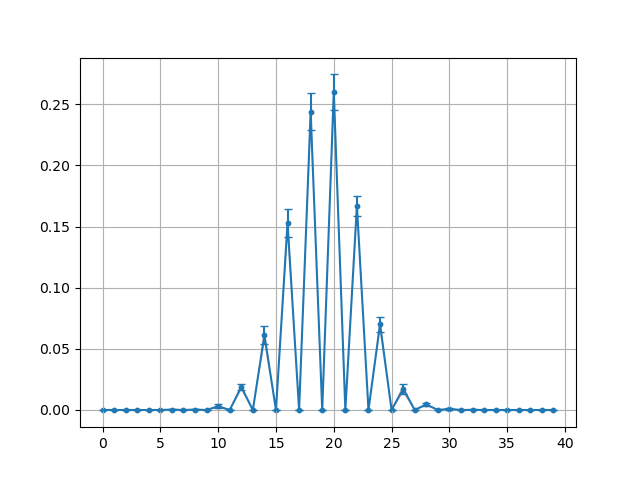

In [14]:
values = res[:,0]
errors = res[:,1]

fig, ax = plt.subplots()#figsize=[8,8])
ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()

# Moments

In [17]:
def calculate_moments(data):
    Y = np.array(data)
    X = np.arange(0, len(Y))

    print(len(Y))

    mean = (X * Y).sum()

    var = ((X**2 * Y).sum()-(X * Y).sum()**2)
    skew = (((X**3 * Y).sum()-3*mean*((X**2 * Y).sum()-mean**2)-mean**3)/(np.sqrt(var)**3))
    kurt = ((X**4 * Y).sum() - 4*mean*((X**3 * Y).sum())+6*mean**2*((X**2 * Y).sum())-3*mean**4)/(var**2) - 3

    print("Sum of probabilites: ",Y.sum())
    print("Expected value: ",mean)
    print("Variance: ", var)
    print("Skewness: ",skew)
    print("Kurtosis: ",kurt)

In [18]:
ave = 0
for f,p in zip(range(len(values)),values):
    ave += f * p

print(ave)

calculate_moments(values)

19.110800000000005
40
Sum of probabilites:  1.0
Expected value:  19.1108
Variance:  9.238923359999944
Skewness:  -0.021706885039939446
Kurtosis:  0.1968324040263476


In [19]:
def Properties(G):
    positive,negative = color_of_frustration(G)
    
    print("N: ",len(G.nodes()))
    print("L: ",len(G.edges()))

    node_colors=nx.get_node_attributes(G,'color')
    #print("Black: ",len([i for i in node_colors.values() if i=="Black"]))
    #print("White: ",len([i for i in node_colors.values() if i=="Silver"])) 
    print("f: ",frustration_count(G))
    print("L-f: ",len(G.edges())-frustration_count(G))

    print("f+: ",positive)
    print("f-: ",negative)
    
    print("Delta: ",positive-negative)
    print("Abs(Delta): ",int(np.sqrt((positive-negative)**2)))

    print(frustration_count(G)/len(G.edges()))

In [28]:
Properties(simulated_annealing(FG(10,0.5),0))

N:  100
L:  180
f:  94
L-f:  86
f+:  47
f-:  47
Delta:  0
Abs(Delta):  0
0.5222222222222223


In [ ]:
24,40,60,84,112,144,180

In [32]:
res_array=[]
for i in range(4,11):
    res = Calculate_Probabilites(i,0)
    res_array.append(res)
    print("\n")

  1%|          | 8/1000 [00:00<00:15, 62.02it/s]

  0%|          | 3/1000 [00:00<00:34, 28.93it/s]

  0%|          | 5/1000 [00:00<00:28, 34.73it/s]

  1%|          | 6/1000 [00:00<00:21, 46.86it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:00<02:57,  5.61it/s]

100%|██████████| 1000/1000 [01:43<00:00,  9.70it/s]

In [33]:
np.save("res_array", res_array)

In [39]:
Exp = []
Var = []

for res in res_array:
    
    values = res[:,0]
    errors = res[:,1]

    calculate_moments(values)
    
    Y = np.array(values)
    X = np.arange(0, len(Y))

    #print(len(Y))

    mean = (X * Y).sum()

    var = ((X**2 * Y).sum()-(X * Y).sum()**2)
    
    Exp.append(mean)
    Var.append(var)
    

24
Sum of probabilites:  1.0
Expected value:  11.141
Variance:  5.4865190000000155
Skewness:  -0.12856344040793483
Kurtosis:  0.5256848811889863
40
Sum of probabilites:  0.9999999999999999
Expected value:  19.1354
Variance:  9.135266839999986
Skewness:  -0.08438047156327441
Kurtosis:  0.2159359923196913
60
Sum of probabilites:  1.0
Expected value:  29.1222
Variance:  14.268267159999937
Skewness:  -0.05874961484335257
Kurtosis:  0.1441549496743071
84
Sum of probabilites:  1.0
Expected value:  41.0286
Variance:  20.035182040000336
Skewness:  0.006814963792403053
Kurtosis:  0.14042501377983774
112
Sum of probabilites:  1.0
Expected value:  55.040400000000005
Variance:  27.123167839999496
Skewness:  -0.015510669628425058
Kurtosis:  0.11894544129707585
144
Sum of probabilites:  1.0
Expected value:  71.04939999999999
Variance:  35.5143596400012
Skewness:  0.03142848848997454
Kurtosis:  0.15074554855325628
180
Sum of probabilites:  1.0
Expected value:  89.1108
Variance:  44.57252335999965
Ske

<IPython.core.display.Javascript object>


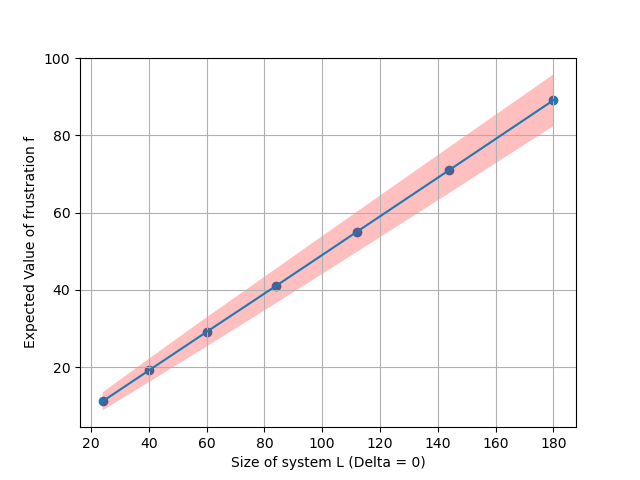

In [50]:
Exp = np.array(Exp)
Var = np.array(Var)


fig, ax = plt.subplots()#figsize=[8,8])
ax.grid()
ax.plot([24,40,60,84,112,144,180],Exp)
ax.scatter([24,40,60,84,112,144,180],Exp)#,s=10)#,marker="x")

ax.fill_between([24,40,60,84,112,144,180], Exp - np.sqrt(Var), Exp + np.sqrt(Var),facecolor="red", alpha=0.25)
ax.set_xlabel("Size of system L (Delta = 0)")
ax.set_ylabel("Expected Value of frustration f")
plt.show()

# Time evolution

In [63]:
H = simulated_annealing(FG(5,0.5),0)
frustrations = []
frustrations.append(frustration_count(H.copy()))

for t in tqdm(range(1,1000)):
    H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)
    
    frustrations.append(frustration_count(H.copy()))
    

100%|██████████| 999/999 [00:00<00:00, 2480.92it/s]


<IPython.core.display.Javascript object>


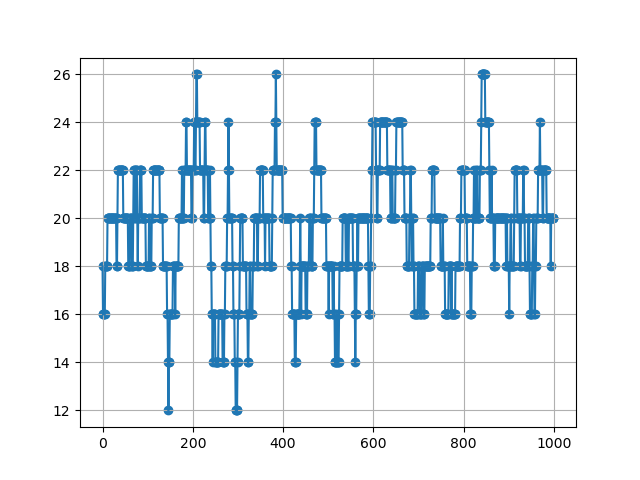

In [61]:
fig, ax = plt.subplots()#figsize=[8,8])
ax.grid()
ax.plot([t for t in range(1000)],frustrations)
ax.scatter([t for t in range(1000)],frustrations)

In [90]:
avg=[]

for i in range(10):

    H = simulated_annealing(FG(5,0.5),0)
    frustrations = []
    frustrations.append(frustration_count(H.copy()))

    for t in tqdm(range(1,100)):
        H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)

        frustrations.append(frustration_count(H.copy()))

    avg.append(frustrations)

100%|██████████| 99/99 [00:00<00:00, 2489.40it/s]


In [91]:
final = []

AVG = np.array(avg)
for i in range(0,len(AVG[0])):
    final.append((np.mean(AVG[:,i]),np.std(AVG[:,i])))
    
FINAL = np.array(final)

<IPython.core.display.Javascript object>


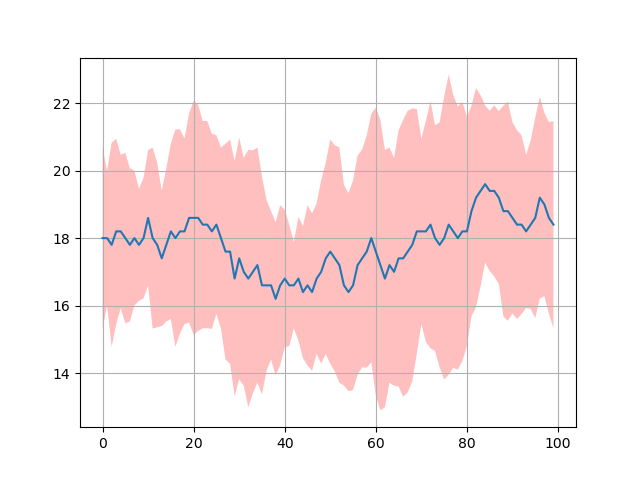

In [92]:
values = FINAL[:,0]
errors = FINAL[:,1]

fig, ax = plt.subplots()#figsize=[8,8])

ax.plot([i for i in range(len(values))],values)#,s=10)#,marker="x")

ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
#ax.errorbar([i for i in range(len(values))],values,errors,capsize=3)
#ax.scatter([i for i in range(len(values))],values,s=10)#,marker="x")
ax.grid()

In [ ]:
def Calculate_Probabilites(size,target):
    probabilites = []
    edges = []
    for i in range(10):
        avg=[]
        for k in tqdm(range(1000)):
            
            H = simulated_annealing(FG(size,0.5),target)

            edges.append(len(H.copy().edges()))
            f = frustration_count(H.copy())
            avg.append(f)

        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

    return np.array(final)

In [163]:
avg=[]

for i in tqdm(range(1000)):

    H = simulated_annealing(FG(5,0.5),0)
    frustrations = []
    frustrations.append(frustration_count(H.copy()))

    for t in range(1,100):
        H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)

        frustrations.append(frustration_count(H.copy()))
         
    avg.append(np.array(frustrations))

100%|██████████| 1000/1000 [00:53<00:00, 18.73it/s]


In [167]:
AVG = np.array(avg)
PROB=[]

for j in range(len(AVG[0])):

    prob=[]
    for i in range(0,len(FG(5,0.5).edges())):
        prob.append(np.count_nonzero(np.array(AVG[:,j]) == i))
    PROB.append(np.array(prob)/1000)

<IPython.core.display.Javascript object>


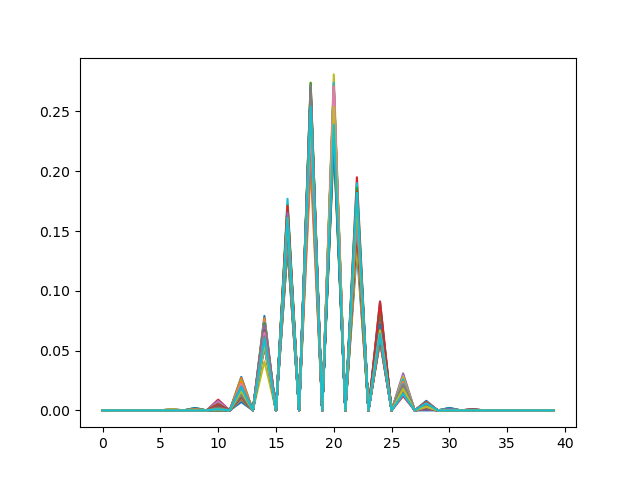

In [168]:
fig, ax = plt.subplots()

for prob in PROB:
    plt.plot([i for i in range(len(prob))],prob)

<IPython.core.display.Javascript object>


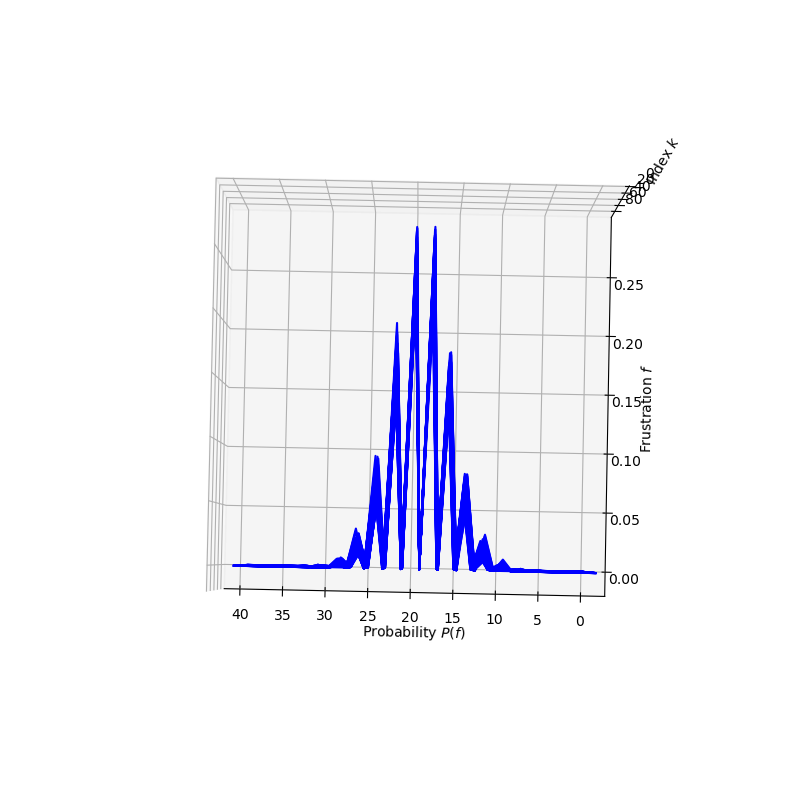

In [169]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')
"""
for j in range(len(avg2)):
    #ax.plot([i for i in range(len(avg[j][:,0]))],avg[j][:,0],j, label='parametric curve')
    ax.plot(avg2[j][:,0],[i for i in range(len(avg2[j][:,0]))],np.linspace(0,1)[j], label='parametric curve',c="blue",alpha=0.4)
"""
for j in range(len(PROB)):
    ax.plot([i for i in range(len(PROB[j]))],PROB[j],j,color="blue")   
    
ax.view_init(azim=0, elev=-20)

ax.set_xlabel('Probability $P(f)$')
ax.set_ylabel('Frustration $f$')
ax.set_zlabel('Index $k$')
plt.show()

<IPython.core.display.Javascript object>


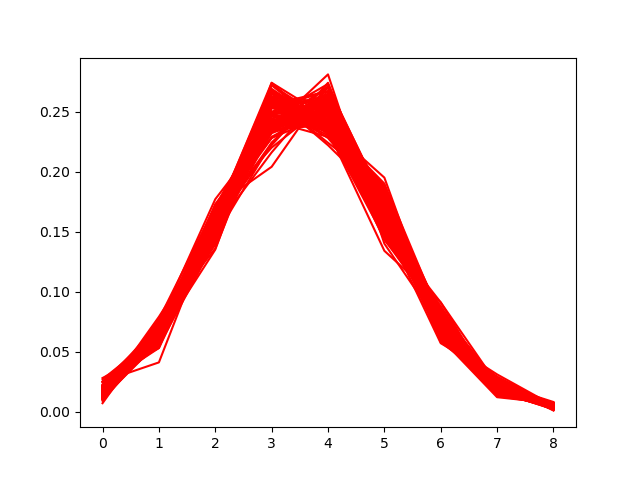

In [173]:

nonzero = []

for prob in PROB:
    nonzero.append([i for i in prob[11:30] if i!=0])

#for i in nonzero:
    #print(np.shape(i))

fig, ax = plt.subplots()#figsize=[8,8]) 
for dat in nonzero:
    ax.plot([i for i in range(len(dat))],dat,c="red")
plt.show()

<IPython.core.display.Javascript object>


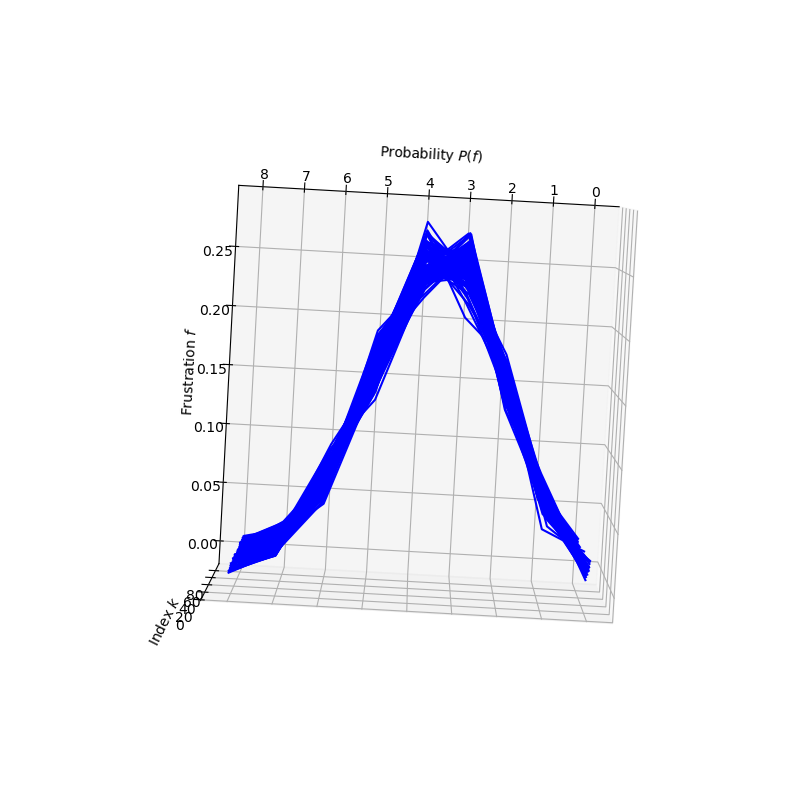

In [175]:
fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')
"""
for j in range(len(avg2)):
    #ax.plot([i for i in range(len(avg[j][:,0]))],avg[j][:,0],j, label='parametric curve')
    ax.plot(avg2[j][:,0],[i for i in range(len(avg2[j][:,0]))],np.linspace(0,1)[j], label='parametric curve',c="blue",alpha=0.4)
"""
for j in range(len(nonzero)):
    ax.plot([i for i in range(len(nonzero[j]))],nonzero[j],j,color="blue")   
    
ax.view_init(azim=0, elev=-20)

ax.set_xlabel('Probability $P(f)$')
ax.set_ylabel('Frustration $f$')
ax.set_zlabel('Index $k$')
plt.show()

# Variance?

In [8]:
avg=[]
for i in tqdm(range(1000)):

    H = simulated_annealing(FG(5,0.5),0)
    frustrations = []
    frustrations.append(frustration_count(H.copy()))

    for t in range(1,100):
        H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)

        frustrations.append(frustration_count(H.copy()))
         
    avg.append(np.array(frustrations))

100%|██████████| 1000/1000 [00:52<00:00, 18.95it/s]


In [9]:
AVG = np.array(avg)
PROB=[]

for j in range(len(AVG[0])):

    prob=[]
    for i in range(0,len(FG(5,0.5).edges())):
        prob.append(np.count_nonzero(np.array(AVG[:,j]) == i))
    PROB.append(np.array(prob)/1000)

In [ ]:
        prob=[]
        for i in range(0,max(edges)):
            prob.append(np.count_nonzero(np.array(avg) == i))
        probabilites.append(prob)

    total = np.array(probabilites)
    final = []
    for i in range(0,len(total[0])):
        final.append((np.mean(total[:,i])/1000,np.std(total[:,i])/1000))

In [67]:
avg=[]
for k in tqdm(range(1)):

    H = simulated_annealing(FG(5,0.5),0)
    #f_t.append(frustration_count(H.copy()))
    
    p_t = []
    for t in range(0,5):

        G = H.copy()
        avg_f=[]
        for i in range(100):
            newG = nx.algorithms.double_edge_swap(G, nswap=1)
            avg_f.append(frustration_count(newG))
            
        avg_prob=[]
        for f in range(edges):
            avg_prob.append(np.count_nonzero(np.array(avg_f) == f))
        
        p_t.append(np.array(avg_prob)/10)
        #H = newG
        
    avg.append(np.array(p_t))

100%|██████████| 1/1 [00:00<00:00, 13.10it/s]


(5, 40)
[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.
  3.8 0.  2.4 0.  1.9 0.  1.  0.  0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  1.  0.  1.3 0.  2.7 0.
  1.8 0.  2.6 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.8 0.  2.5 0.
  4.7 0.  1.6 0.  0.2 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.3 0.  2.  0.
  2.6 0.  2.9 0.  0.7 0.  0.5 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.1 0.  2.9 0.
  3.4 0.  2.6 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0. ]]


<IPython.core.display.Javascript object>


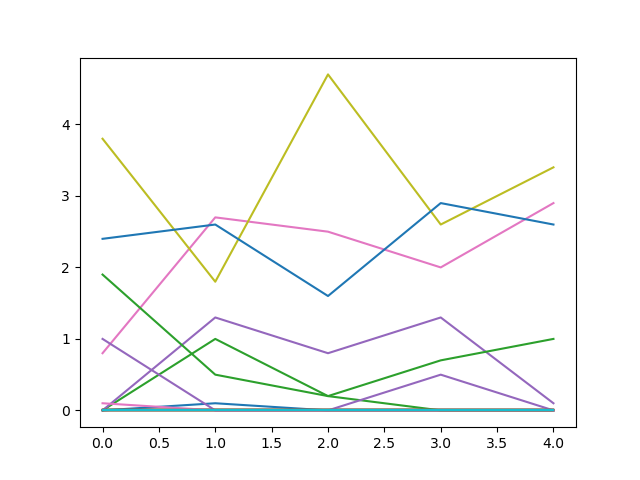

In [69]:
AVG = np.array(avg)
for p_t in AVG:
    print(np.shape(p_t))
    print(p_t)
    
    fig, ax = plt.subplots()
    ax.plot([i for i in range(len(p_t))],p_t)

40
[22 18 20 16 22 22 16 18 18 18 18 16 18 22 22 20 18 18 22 22 16 16 18 14
 18 24 20 14 20 22 18 20 18 20 16 18 18 12 14 22 18 20 22 24 20 18 20 18
 26 24 24 20 24 18 20 12 22 18 16 20 18 18 14 20 18 24 20 20 18 18 20 22
 16 16 20 18 20 16 22 22 16 18 20 24 16 24 20 22 18 18 18 20 16 22 22 18
 14 20 16 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  5  0 15  0 30  0 22  0 17  0
  8  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.002 0.    0.005 0.    0.015 0.    0.03  0.    0.022 0.    0.017 0.
 0.008 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


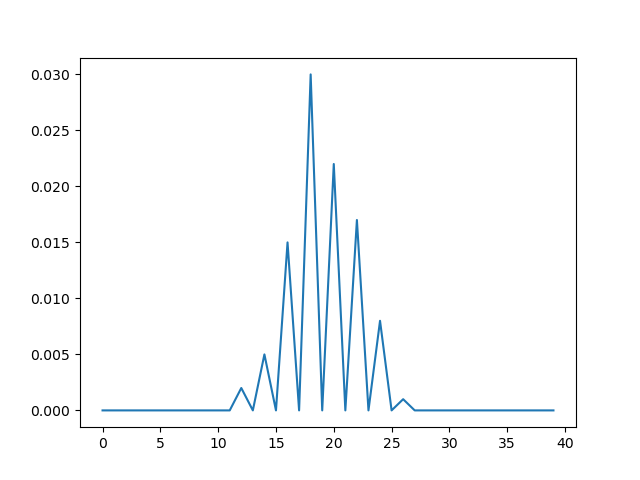

[22 16 20 16 20 20 16 16 16 18 20 16 18 22 24 20 18 18 22 22 16 16 16 14
 16 24 20 14 18 20 18 20 18 20 16 16 20 12 12 22 18 20 24 22 20 18 18 16
 24 24 24 22 24 18 22 12 22 18 16 18 18 18 14 18 18 24 20 20 18 18 20 22
 18 16 20 18 20 16 22 20 16 18 18 24 16 24 22 22 18 20 18 20 16 20 22 18
 14 20 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  4  0 20  0 27  0 22  0 14  0
 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.004 0.    0.02  0.    0.027 0.    0.022 0.    0.014 0.
 0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


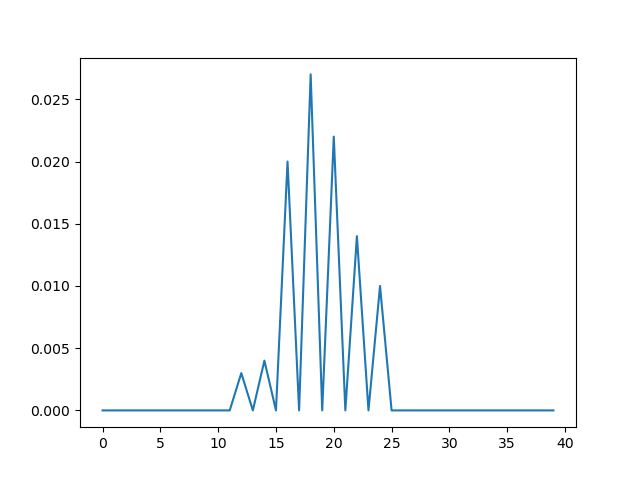

[20 16 20 16 20 20 16 16 14 16 20 16 18 22 22 20 18 18 20 22 16 16 16 14
 16 22 20 14 16 20 20 20 18 20 16 16 20 12 12 22 18 18 22 22 20 18 18 16
 26 24 24 20 24 18 22 12 22 18 16 20 20 18 16 18 18 24 20 22 18 18 20 22
 20 18 20 18 20 18 22 20 16 18 18 24 16 24 22 22 18 18 20 18 16 18 22 18
 14 20 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  4  0 20  0 26  0 25  0 15  0
  6  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.004 0.    0.02  0.    0.026 0.    0.025 0.    0.015 0.
 0.006 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


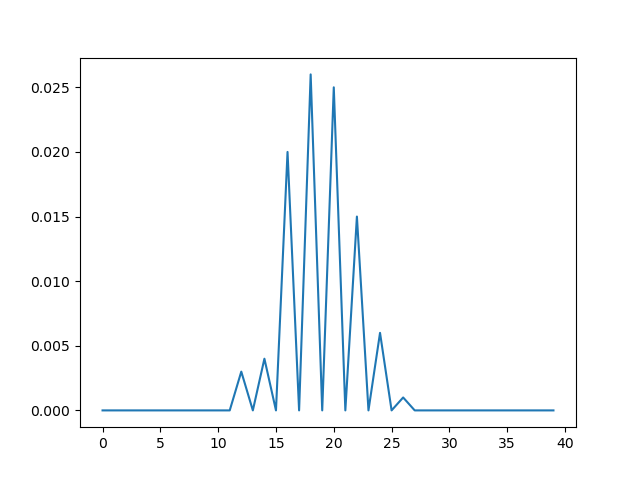

[18 16 22 18 20 20 16 16 16 16 20 14 18 22 22 20 18 18 22 22 16 16 18 16
 16 20 20 14 18 22 18 20 18 20 16 16 20 12 12 22 18 18 22 24 20 18 18 18
 26 24 22 20 24 20 22 12 22 20 16 20 20 18 14 18 18 24 20 22 18 18 20 22
 18 16 20 18 20 18 24 20 16 18 18 24 16 24 22 24 18 18 18 18 16 18 22 18
 16 20 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  3  0 18  0 31  0 21  0 15  0
  8  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.003 0.    0.018 0.    0.031 0.    0.021 0.    0.015 0.
 0.008 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


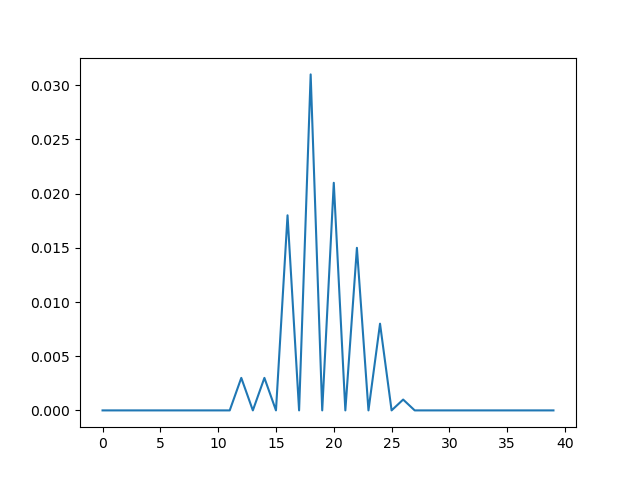

[18 16 22 18 18 18 16 16 16 16 20 14 18 22 22 18 18 18 22 22 18 18 18 14
 18 20 20 14 16 24 18 22 18 20 16 16 20 12 12 20 20 18 22 24 20 18 18 20
 26 24 22 20 24 20 22 12 22 20 18 20 20 18 12 16 18 24 20 22 18 20 20 24
 18 16 20 18 20 18 24 20 14 16 18 24 18 24 22 24 18 18 16 16 18 18 22 16
 16 20 20 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  4  0  4  0 16  0 30  0 22  0 13  0
 10  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.004 0.    0.004 0.    0.016 0.    0.03  0.    0.022 0.    0.013 0.
 0.01  0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


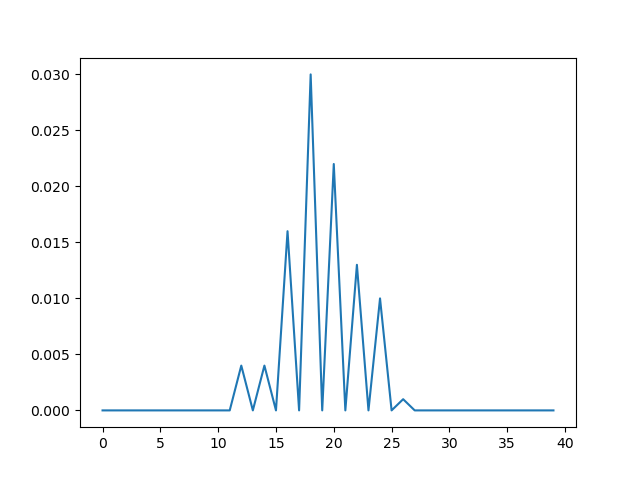

[18 16 22 18 18 18 18 16 16 16 18 14 18 22 22 18 18 20 24 22 20 18 18 14
 18 20 18 12 16 24 16 22 18 20 16 16 20 12 14 20 20 18 22 24 20 18 20 20
 26 24 22 20 24 20 20 14 24 20 18 18 20 20 12 16 18 24 20 20 18 18 20 24
 18 16 20 18 20 18 24 20 14 16 18 22 18 24 22 24 18 20 16 16 18 18 22 16
 18 20 20 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  5  0 15  0 30  0 25  0 10  0
 11  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.005 0.    0.015 0.    0.03  0.    0.025 0.    0.01  0.
 0.011 0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


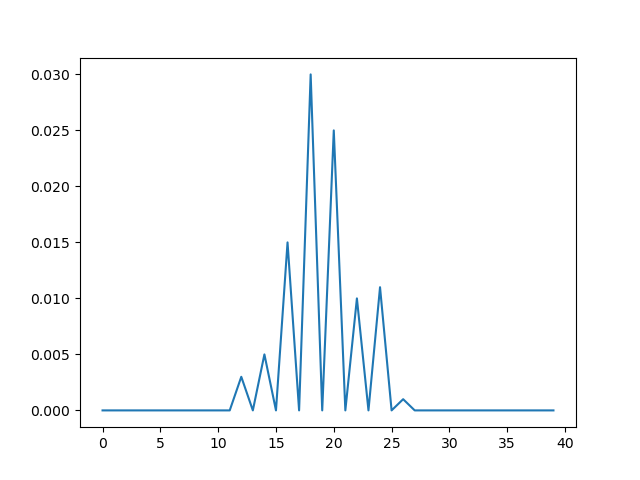

[18 16 22 18 16 18 18 16 16 16 18 14 20 22 22 20 18 20 24 20 20 18 18 14
 16 20 18 12 16 24 16 20 16 18 18 16 20 12 14 18 20 18 22 22 18 18 18 20
 24 22 22 18 22 20 20 12 22 22 18 18 20 18 14 18 18 24 20 22 18 20 22 24
 18 18 20 18 20 18 24 20 16 18 18 22 20 24 24 24 20 20 18 16 18 18 20 16
 18 20 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  4  0 14  0 34  0 23  0 13  0
  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.004 0.    0.014 0.    0.034 0.    0.023 0.    0.013 0.
 0.009 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


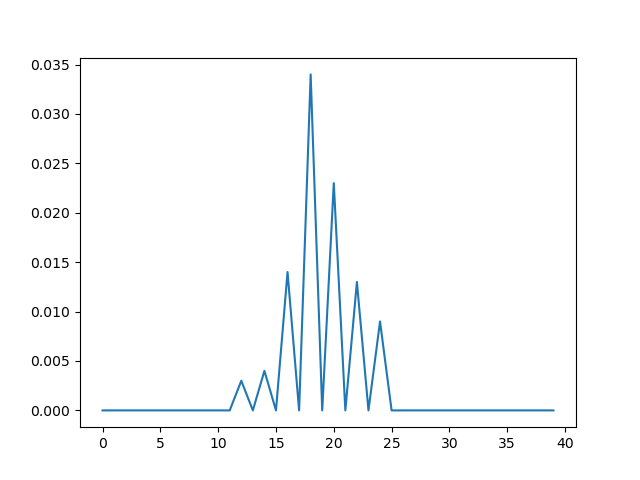

[18 18 22 18 16 18 16 16 16 14 18 12 20 22 20 20 18 18 24 20 22 18 18 14
 16 20 18 12 16 24 16 20 16 18 20 16 20 12 16 18 20 18 22 24 18 18 18 20
 24 22 24 18 22 18 20 12 22 22 18 18 20 20 14 18 18 22 20 22 18 20 20 24
 18 20 18 18 22 18 24 18 18 18 18 20 20 22 24 22 18 20 18 16 16 18 20 18
 18 18 16 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  4  0  3  0 14  0 37  0 21  0 13  0
  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.004 0.    0.003 0.    0.014 0.    0.037 0.    0.021 0.    0.013 0.
 0.008 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


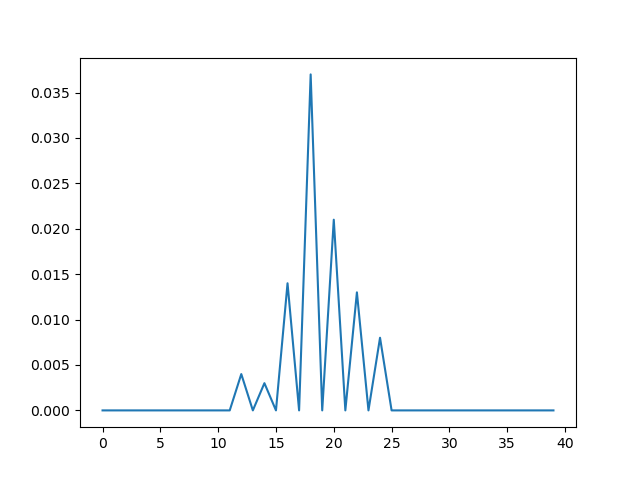

[20 18 20 18 16 16 14 16 16 16 18 12 20 22 20 20 18 18 22 22 22 18 20 14
 16 20 18 14 18 24 18 18 16 20 20 16 18 12 18 18 20 18 22 24 18 20 18 18
 24 20 26 16 22 18 20 12 24 22 18 18 20 20 14 18 18 22 20 22 20 20 22 24
 20 20 18 18 22 16 24 18 18 18 20 18 20 22 26 20 20 22 20 16 16 18 22 20
 20 18 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  3  0  4  0 13  0 31  0 27  0 14  0
  6  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.003 0.    0.004 0.    0.013 0.    0.031 0.    0.027 0.    0.014 0.
 0.006 0.    0.002 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


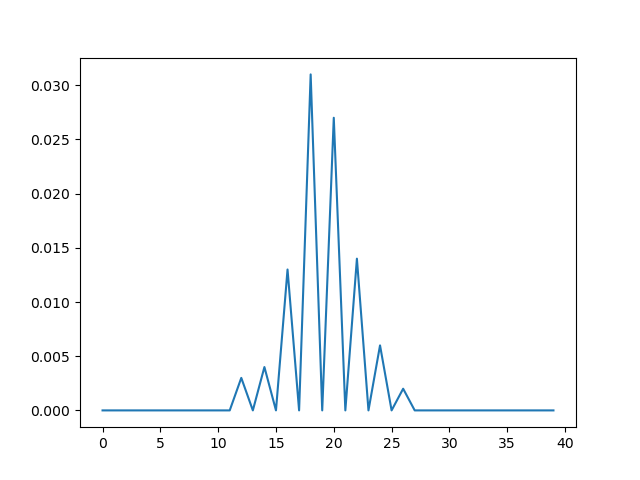

[20 20 20 18 18 18 14 16 16 18 18 12 22 22 20 18 18 18 24 22 22 18 22 14
 16 20 18 14 16 24 20 20 16 18 22 18 18 12 16 18 20 20 22 26 18 20 18 18
 24 18 26 16 20 18 22 14 24 22 18 18 20 20 14 18 18 22 20 22 20 20 22 24
 20 20 18 16 22 16 24 18 18 18 20 16 22 22 26 20 20 22 18 16 16 18 22 20
 18 18 18 16]
[ 0  0  0  0  0  0  0  0  0  0  0  0  2  0  5  0 13  0 32  0 22  0 17  0
  6  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0]
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.002 0.    0.005 0.    0.013 0.    0.032 0.    0.022 0.    0.017 0.
 0.006 0.    0.003 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.   ]
0.0025


<IPython.core.display.Javascript object>


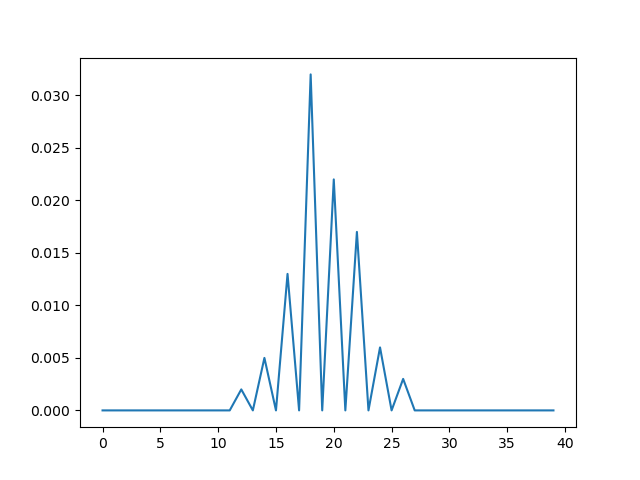

In [41]:
H = simulated_annealing(FG(5,0.5),0)

edges = len(H.edges())

print(edges)

avg_prob_t=[]
for t in range(len(AVG[0])):
    print(AVG[:,t])
    prob = []
    for f in range(edges):
        prob.append(np.count_nonzero(np.array(AVG[:,t]) == f))
    
    prob = np.array(prob)
    print(prob)
    print(prob/1000)
    print((np.mean(prob)/1000))
    
    fig, ax = plt.subplots()
    ax.plot([i for i in range(len(prob))],(prob/1000))
    
    
        
    avg_prob_t.append((np.mean(prob)/1000,np.std(prob)/1000))
    

In [25]:
avg_prob_t

[(0.00025, 0.0006224949798994366),
 (0.00025, 0.0006614378277661477),
 (0.00025, 0.000733143914930759),
 (0.00025, 0.000733143914930759),
 (0.00025, 0.000698212002188447),
 (0.00025, 0.000698212002188447),
 (0.00025, 0.000733143914930759),
 (0.00025, 0.000733143914930759),
 (0.00025, 0.0008874119674649424),
 (0.00025, 0.00082915619758885)]

In [ ]:
avg=[]
for k in tqdm(range(1)):

    H = simulated_annealing(FG(5,0.5),0)
    #f_t.append(frustration_count(H.copy()))
    
    p_t = []
    for t in range(0,5):

        G = H.copy()
        avg_f=[]
        for i in range(100):
            newG = nx.algorithms.double_edge_swap(G, nswap=1)
            avg_f.append(frustration_count(newG))
            
        avg_prob=[]
        for f in range(edges):
            avg_prob.append(np.count_nonzero(np.array(avg_f) == f))
        
        p_t.append(np.array(avg_prob)/10)
        #H = newG
        
    avg.append(np.array(p_t))

In [102]:
avg_f_t=[]
for k in tqdm(range(100)):

    H = simulated_annealing(FG(5,0.5),0)

    f_t=[]
    f_t.append(frustration_count(H.copy()))
    for t in range(1,1000):

        H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)
        f_t.append(frustration_count(H))
    
    avg_f_t.append(f_t)

    

100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


In [103]:
AVG = np.array(avg_f_t)
AVG

array([[22, 22, 22, ..., 18, 18, 18],
       [18, 18, 18, ..., 22, 22, 22],
       [20, 20, 20, ..., 14, 14, 14],
       ...,
       [18, 18, 18, ..., 20, 22, 24],
       [20, 20, 20, ..., 16, 14, 16],
       [20, 20, 20, ..., 18, 20, 18]])

In [104]:
mean_f=[]
std_f = []
for i in range(len(AVG[0])):
    mean_f.append(np.mean(AVG[:,i]))
    std_f.append(np.std(AVG[:,i]))
    

values = np.array(mean_f)
errors = np.array(std_f)

<IPython.core.display.Javascript object>


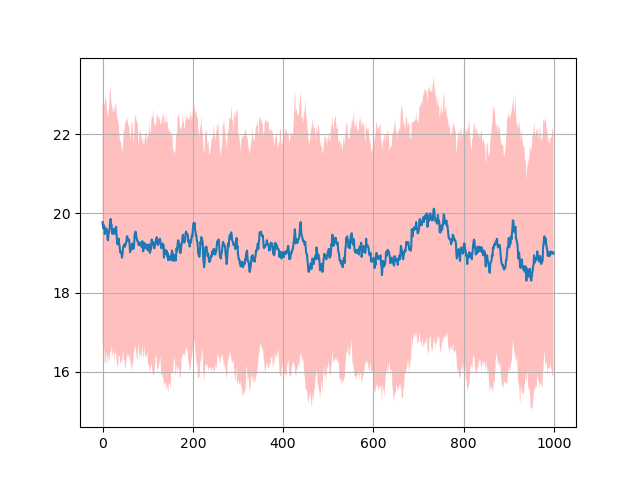

In [105]:
fig, ax = plt.subplots()

ax.plot([i for i in range(len(values))],values)#,s=10)#,marker="x")

ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.grid()

In [118]:
AVG_p_at_t=[]
for i in range(len(AVG[0])):

    p_at_t=[]
    for f in range(edges):
        p_at_t.append(np.array(np.count_nonzero(np.array(AVG[:,i]) == f))/len(AVG[:,i]))
    
    AVG_p_at_t.append(p_at_t)
        
P_at_t=np.array(AVG_p_at_t)

In [119]:
np.shape(P_at_t)

(1000, 40)

<IPython.core.display.Javascript object>


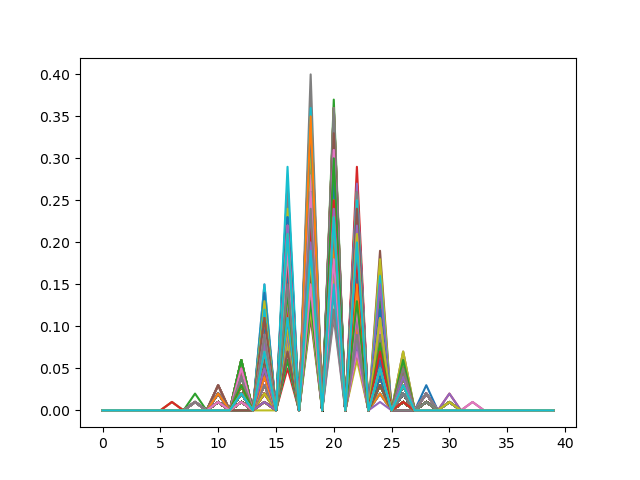

<IPython.core.display.Javascript object>


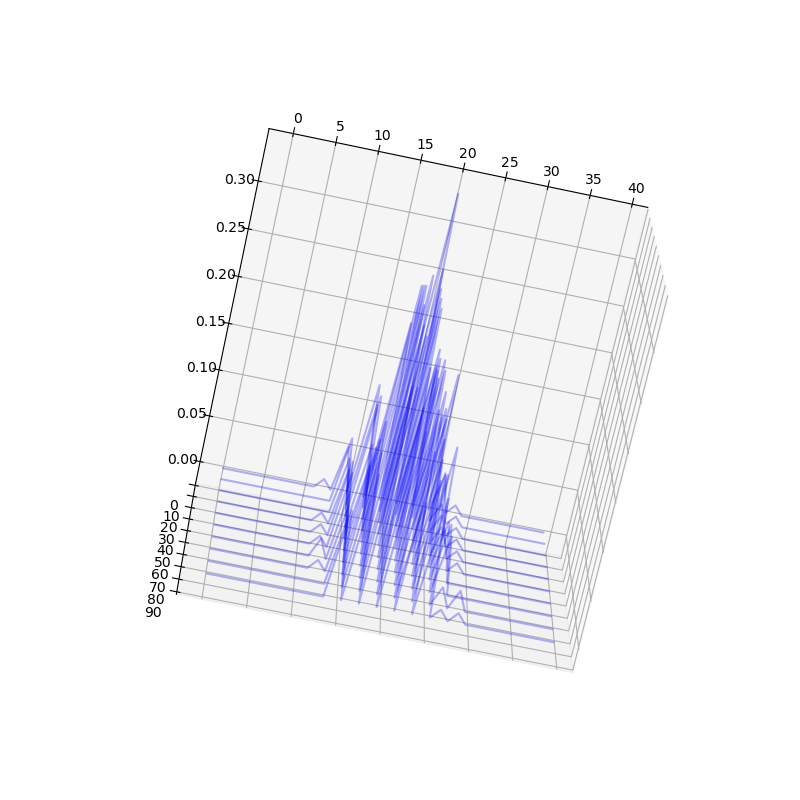

In [131]:
fig, ax = plt.subplots()

for p in P_at_t:
    ax.plot([i for i in range(len(p))],p)#,s=10)#,marker="x")

fig = plt.figure(figsize=[8,8])
ax = fig.gca(projection='3d')

for j in range(len(P_at_t)+10-len(P_at_t)):
    ax.plot([i for i in range(len(P_at_t[j]))],P_at_t[j],j*10,color="blue",alpha=0.3)   

<IPython.core.display.Javascript object>


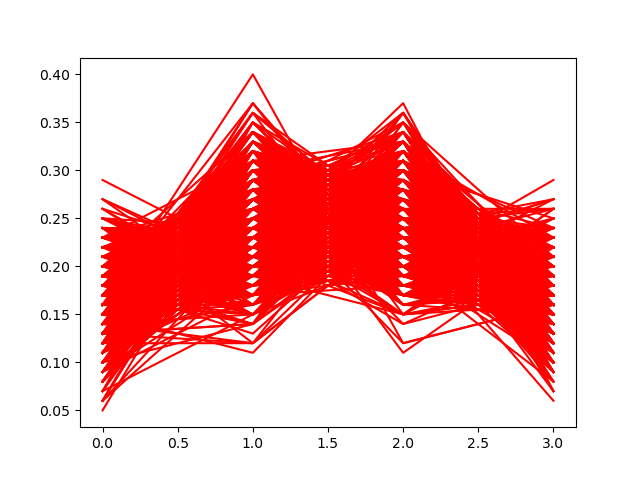

In [138]:

nonzero = []

for prob in P_at_t:
    nonzero.append([i for i in prob[15:24] if i!=0])

#for i in nonzero:
    #print(np.shape(i))

fig, ax = plt.subplots()#figsize=[8,8]) 
for dat in nonzero:
    ax.plot([i for i in range(len(dat))],dat,c="red")
plt.show()

# LETSGO

In [139]:
avg_f_t=[]
for k in tqdm(range(100)):

    H = simulated_annealing(FG(10,0.5),0)

    f_t=[]
    f_t.append(frustration_count(H.copy()))
    for t in range(1,1000):

        H = nx.algorithms.double_edge_swap(H.copy(), nswap=1)
        f_t.append(frustration_count(H))
    
    avg_f_t.append(f_t)


100%|██████████| 100/100 [01:44<00:00,  1.04s/it]


In [144]:
AVG = np.array(avg_f_t)

mean_f=[]
std_f = []
for i in range(len(AVG[0])):
    mean_f.append(np.mean(AVG[:,i]))
    std_f.append(np.std(AVG[:,i]))
    

values = np.array(mean_f)
errors = np.array(std_f)

<IPython.core.display.Javascript object>


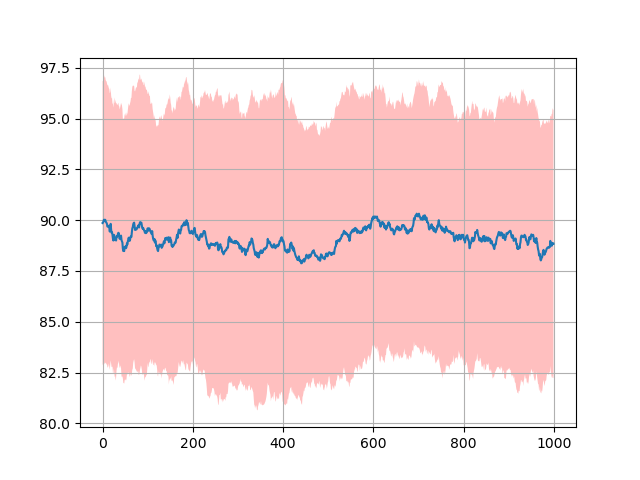

In [145]:
fig, ax = plt.subplots()

ax.plot([i for i in range(len(values))],values)#,s=10)#,marker="x")

ax.fill_between([i for i in range(len(values))], values - errors, values + errors,facecolor="red", alpha=0.25)#, edgecolor="black")
ax.grid()